In [364]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Callable
import backtester_utils as bt
%load_ext autoreload
%autoreload 2

<Axes: >

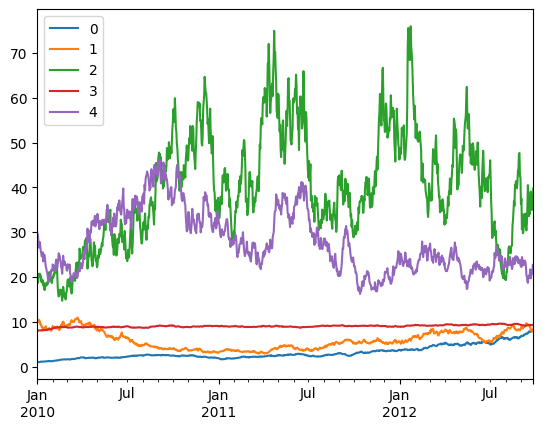

In [246]:
np.random.seed(22)
contract_size = pd.Series([25, 1, 5, 3, 10])
T = 1000
df_ret = pd.DataFrame(np.random.normal(loc=0.001, scale=0.02, size=(T, 5)))
df_ret.index = pd.date_range('2010-01-01', periods=T)
df_ret = df_ret *np.array([1.0, 1.5, 3.0, 0.2, 2.0]) + 1
df_ret.iloc[0] = [1, 10, 20, 8, 30]
df_ret
df_price =  (df_ret).cumprod()
### df_dict
attributes = ['high', 'close', 'low', 'max', 'trend']
df_dict = {}

for attribute in attributes:
    window = np.random.randint(5, 101)
    df_signal = (df_price.pct_change(window).shift(-window+1) + np.random.normal(scale=0.5, size=df_ret.shape)).shift().ffill().bfill() * 100
    df_signal = df_signal.rolling(20).mean()

    df_signal = df_signal/df_signal.std()
    df_dict[attribute] = df_signal
    
df_dict['price'] = df_price
df_dict['low'] = df_dict['low'].drop(0 ,axis=1)




df_price.plot()

In [354]:

def backtester(df_forecast: pd.DataFrame, df_price: pd.DataFrame, contract_size: pd.Series=None, shift_signal: int=2, pos_mul_series: pd.Series=None, df_eligibles:pd.DataFrame=None):
    df_nominal = df_forecast.copy()
    if df_eligibles is not None:
        df_nominal = df_nominal * df_eligibles
    
    if pos_mul_series is not None:
        df_nominal = df_nominal.mul(pos_mul_series, axis='index')
    df_units = df_nominal/ (df_price * contract_size).dropna(how='all', axis=1)
    df_weights = df_nominal.div(df_nominal.abs().sum(axis=1), axis='index')
    df_nominal = df_nominal.shift(shift_signal)
    df_pnl_nominal = (df_nominal * df_price.pct_change())
    df_pnl_capital = (df_nominal.div(df_nominal.abs().sum(axis=1), axis='index') * df_price.pct_change())

    return df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital


def get_strat_scalar(df_pnl_nominal: pd.DataFrame, nominal_target_vol: float):
    df_pnl_rolling_vol = df_pnl_nominal.sum(axis=1).rolling(25).std().mul(np.sqrt(252)).replace(0, np.NaN)
    strat_scalar_series = nominal_target_vol/df_pnl_rolling_vol
    return strat_scalar_series


def main_backtester(df_forecast: pd.DataFrame, df_price: pd.DataFrame, contract_size: pd.Series=None,
                    shift_signal: int=2, nominal_target_vol: float=1_000_000, vol_target: bool =True,
                    shift_strat_scalar: int=2, df_eligibles: pd.DataFrame=None):
    
    if contract_size is None:
        print('No contract_size provided, contract_size is assumed to be 1')
        contract_size = pd.Series([1]*df_forecast.shape[1])

    df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital = backtester(df_forecast=df_forecast, df_price=df_price, contract_size=contract_size, shift_signal=shift_signal, pos_mul_series=None,
                                                                                  df_eligibles=df_eligibles)
    if vol_target:
        strat_scalar_series = get_strat_scalar(df_pnl_nominal, nominal_target_vol)
        df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital = backtester(df_forecast=df_forecast, df_price=df_price, contract_size=contract_size, shift_signal=shift_signal, pos_mul_series=strat_scalar_series.shift(shift_strat_scalar),
                                                                                      df_eligibles=df_eligibles)
    return df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital

def reindex_and_ffill(df, index, limit=10):
    dfc = df.reindex(index).ffill(limit=limit).dropna(how='all', axis=0)
    return dfc


def check_strings_and_return_missing(list1, list2):
    missing_items = [item for item in list1 if item not in list2]
    if missing_items:
        raise ValueError(f"Missing items: {missing_items}")
    return True

contract_size = pd.Series([1, 2, 10, 4, 5, 10, 20 ,2])
contract_size = {k : np.random.randint(1, 20) for k in range(df_ret.shape[1])}
df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital = main_backtester(df_signal, df_price)


### Things need to be built
### Drop Largest K
### Shuffling time series, shuffing asset_picking

No contract_size provided, contract_size is assumed to be 1


In [365]:
def reindex_and_ffill(df, index, limit=10):
    dfc = df.reindex(index).ffill(limit=limit).dropna(how='all', axis=0)
    return dfc


def get_df_eligibles(df_price, thres=5):
    df_pricec = df_price.copy().ffill()
    eligible_price_checker = (df_pricec != df_pricec.shift(1)).bfill() * 1
    df_eligibles = (eligible_price_checker.rolling(thres).mean().fillna(1) > 0)*1
    return df_eligibles

def shuffle_weights(df_position, df_eligibles, axis='time'):
    df_eligiblec = df_eligibles.reindex(df_position.index).fillna(0)
    
    
    def helper(positions, eligibles):
        new_positions = deepcopy(positions)
        for idx in range(positions.shape[1]):
            eligible_indices = np.where(eligibles[:, idx] == 1)[0]
            eligible_values = deepcopy(positions[:, idx][eligible_indices])
            np.random.shuffle(eligible_values)
            new_positions[:, idx][eligible_indices] = eligible_values
        return new_positions

    if axis == 'time':
        positions, eligibles = deepcopy(df_position.values), deepcopy(df_eligiblec.values)
        new_positions = helper(positions, eligibles)
    elif axis == 'cross':
        positions, eligibles = deepcopy(df_position.values).T, deepcopy(df_eligiblec.values).T
        new_positions = helper(positions, eligibles).T
        
    if axis == 'both':
        positions, eligibles = deepcopy(df_position.values).T, deepcopy(df_eligiblec.values).T
        new_positions = helper(positions, eligibles).T
        df_new_positions = pd.DataFrame(new_positions, index=df_position.index, columns=df_position.columns)
        positions, eligibles = deepcopy(df_new_positions.values), deepcopy(df_eligiblec.values)
        new_positions = helper(positions, eligibles)
        
    return pd.DataFrame(new_positions, index=df_position.index, columns=df_position.columns)

def execution_sensitivity_check(df_position, shift_window=1, df_eligibles=None):
    return df_position.shift(shift_window)

def calc_stats(df_pnl_capital):
    df_pnl_capitalc = df_pnl_capital.dropna(how='all', axis=0).fillna(0)
    pnl_series = df_pnl_capitalc.mean(axis=1)
    daily_ret = pnl_series.mean()
    daily_std = pnl_series.std()
    ann_ret = daily_ret * 252
    ann_std = daily_std*np.sqrt(252)
    sharpe = daily_ret/daily_std * np.sqrt(252)
    high_watermark = pnl_series.cumsum().cummax()
    average_dd = (high_watermark - pnl_series.cumsum()).mean()
    max_dd = (high_watermark - pnl_series.cumsum()).max()
    stats_dict = {'daily_ret': daily_ret,
                  'daily_std': daily_std,
                  'ann_ret': ann_ret,
                  'ann_std': ann_std,
                  'sharpe': sharpe,
                  'average_dd': average_dd,
                  'max_dd': max_dd}
    return stats_dict

class AbstractImplementationException(Exception):
    pass

class Alpha():

    def __init__(self, df_dict: dict, start: str, end: str,
                 nominal_target_vol: float, contract_size: dict, shift_signal: int=2,
                 pre_compute_params: dict={}, post_compute_params: dict={}):
        self.df_dict = deepcopy(df_dict)
        self.start = start 
        self.end = end
        self.nominal_target_vol = nominal_target_vol
        self.df_price = df_dict['price']
        self.contract_size = pd.Series(contract_size)
        self.shift_signal = shift_signal
        self.pre_compute_params = pre_compute_params
        self.post_compute_params = post_compute_params
        self.date_range = pd.date_range(start=self.start,end=self.end, freq="D")
        
    def pre_compute(self, date_range: pd.DatetimeIndex=None):
        '''
        Compute all the things you need for the signal
        '''
        pass

    def post_compute(self, date_range: pd.DatetimeIndex=None):
        '''
        Compute df_forecast
        '''
        pass

    def compute_signal_distribution(self):
        raise AbstractImplementationException("no concrete implementation for signal generation")

    def compute_meta_info(self):
        self.df_eligibles = get_df_eligibles(self.df_price, 5)
    
    def run_backtest(self):
        if not hasattr(self, 'df_eligibles'):
            self.compute_meta_info() ##get_df_eligibles
        if not hasattr(self, 'df_alpha'):
            self.pre_compute(self.date_range) ##get df_forecast
        if not hasattr(self, 'df_forecast'):
            self.post_compute()
        if not hasattr(self, 'contract_size'):
            self.contract_size = None
        if not hasattr(self, 'df_eligibles'):
            self.df_eligibles = None
            
        self.compute_signal_distribution()

        df_weights, df_nominal, df_units, df_pnl_nominal, df_pnl_capital = main_backtester(df_forecast=self.df_forecast, df_price=self.df_price, contract_size=self.contract_size, shift_signal=self.shift_signal,
                                                                                           nominal_target_vol=self.nominal_target_vol, vol_target=True, shift_strat_scalar=2,
                                                                                           df_eligibles=self.df_eligibles)
        self.df_weights = df_weights.dropna(how='all', axis=0)
        self.df_nominal = df_nominal.dropna(how='all', axis=0)
        self.df_units = df_units.dropna(how='all', axis=0)
        self.df_pnl_nominal = df_pnl_nominal.dropna(how='all', axis=0)
        self.df_pnl_capital = df_pnl_capital.dropna(how='all', axis=0)

    def run_robustness_tests(self, n_sim=10):
        '''
        Generates df_robustness_tests
        '''
        def helper(self, generator_func: Callable, kwargs:dict):
            selfc = deepcopy(self)
            selfc.pre_compute()
            selfc.post_compute()
            selfc.df_forecast = generator_func(df_position=selfc.df_forecast, df_eligibles=self.df_eligibles, **kwargs)

            selfc.run_backtest()
            stats = calc_stats(selfc.df_pnl_capital)
            return stats
        
        cross_section_stats_list = [helper(self, shuffle_weights, {'axis':'cross'}) for _ in range(n_sim)]
        time_stats_list = [helper(self, shuffle_weights, {'axis':'time'})  for _ in range(n_sim)]
        shuffle_both_axis_list = [helper(self, shuffle_weights, {'axis':'both'})  for _ in range(n_sim)]
        execution_sensitivity_checks = [helper(self, execution_sensitivity_check, {'shift_window': i}) for i in range(n_sim)]
        self.df_robustness_stats = pd.concat([pd.DataFrame(cross_section_stats_list),
                                              pd.DataFrame(time_stats_list),
                                              pd.DataFrame(shuffle_both_axis_list),
                                              pd.DataFrame(execution_sensitivity_checks)], axis=1, keys=['Cross-Section', 'Time-Series', 'Both', 'Execution'])
        
    
    def pnl_decomposition(self, groupings: dict, cost_list: list, df_factors: pd.DataFrame = None):
        ### Long-Short-Decomposition
        if not hasattr(self, 'df_pnl_capital'):
            self.run_backtest()
        
        def get_pnl_with_tc(self, tc: float):
            selfc = deepcopy(self)
            df_nominal_tc = selfc.df_nominal.diff().abs() * tc
            selfc.df_pnl_nominal = selfc.df_pnl_nominal - df_nominal_tc
            selfc.df_pnl_capital = selfc.df_pnl_nominal.div(selfc.df_nominal.abs().sum(axis=1), axis='index').fillna(0)
            return selfc
        
        ### TC Decomposition
        strat_with_tc = [(get_pnl_with_tc(self, tc)) for tc in cost_list]
        stats_with_tc = [calc_stats(self_.df_pnl_capital) for self_ in strat_with_tc]
        
        df_stats_with_tc = pd.DataFrame(stats_with_tc, index=cost_list)    
        self.df_pnl_with_tc = pd.concat([(self_.df_pnl_capital) for self_ in strat_with_tc], axis=1, keys=cost_list)
        self.df_stats_with_tc = df_stats_with_tc
        
        ### Long-Short Decomposition
        df_pnl_capital_long = self.df_pnl_capital * (np.sign(self.df_forecast) == 1)
        df_pnl_capital_short = self.df_pnl_capital * (np.sign(self.df_forecast) == -1)
        self.df_pnl_capital_long_short = pd.concat([df_pnl_capital_long, df_pnl_capital_short], axis=1, keys=['Long', 'Short']).fillna(0)

        ### Factor Decomposition
        
        
class Strat1(bt.Alpha):
    
    def __init__(self, df_dict: dict, start: str, end: str,
                 nominal_target_vol: float, contract_size: dict, shift_signal: int=2,
                 pre_compute_params: dict={}, post_compute_params: dict={}):
        super().__init__(df_dict, start, end,
                         nominal_target_vol, contract_size, shift_signal,
                         pre_compute_params, post_compute_params)
        
    def pre_compute(self, date_range: pd.DatetimeIndex=None):
        if date_range is None:
            date_range = self.date_range
            
        df_high, df_low = deepcopy(self.df_dict['high']), deepcopy(self.df_dict['low'])
        df_high, df_low = reindex_and_ffill(df_high, date_range), reindex_and_ffill(df_low, date_range)
        df_alpha = df_high + df_low
        self.df_alpha = df_alpha.dropna(how='all', axis=0)
        
    def post_compute(self, date_range: pd.DatetimeIndex=None):
        if date_range is None:
            date_range = self.date_range
        self.df_forecast = self.df_alpha
    
    def compute_signal_distribution(self):
        pass
    
    
class Strat2(bt.Alpha):
    
    def __init__(self, df_dict: dict, start: str, end: str,
                 nominal_target_vol: float, contract_size: dict, shift_signal: int=2,
                 pre_compute_params: dict={}, post_compute_params: dict={}):
        super().__init__(df_dict, start, end,
                         nominal_target_vol, contract_size, shift_signal,
                         pre_compute_params, post_compute_params)
        
    def pre_compute(self, date_range: pd.DatetimeIndex):
        if date_range is None:
            date_range = self.date_range
            
        df_trend = deepcopy(self.df_dict['trend'])
        df_forecast = reindex_and_ffill(df_trend, date_range)
        self.df_forecast = df_forecast.dropna(how='all', axis=0)
    
    def post_compute(self, date_range: pd.DatetimeIndex=None):
        if date_range is None:
            date_range = self.date_range
        self.df_forecast = self.df_alpha
    
    def compute_signal_distribution(self):
        pass  
        
class StratWithParam(bt.Alpha):
    def __init__(self, df_dict: dict, start: str, end: str,
                 nominal_target_vol: float, contract_size: dict, shift_signal: int=2,
                 pre_compute_params: dict={}, post_compute_params: dict={}):
        
        super().__init__(df_dict, start, end,
                         nominal_target_vol, contract_size, shift_signal,
                         pre_compute_params, post_compute_params)
        pre_compute_compulsory_params = ['attribute']
        post_compute_compulsory_params = ['rolling_window']
        
        check_strings_and_return_missing(pre_compute_compulsory_params, list(pre_compute_params.keys()))
        check_strings_and_return_missing(post_compute_compulsory_params, list(post_compute_params.keys()))

        
    def pre_compute(self, date_range: pd.DatetimeIndex=None):
        if date_range is None:
            date_range = self.date_range
        attribute = self.pre_compute_params['attribute']
        df_forecast = reindex_and_ffill(self.df_dict[attribute], date_range)
        self.df_forecast = df_forecast.dropna(how='all', axis=0)
    
    def post_compute(self, date_range: pd.DatetimeIndex=None):
        rolling_window = self.post_compute_params['rolling_window']
        if date_range is None:
            date_range = self.date_range
        self.df_forecast = self.df_alpha.rolling(rolling_window).mean()
        
    def compute_signal_distribution(self):
        pass
    


class Portfolio(Alpha):
    
    def __init__(self, strat_dict: dict, start: str, end: str, nominal_target_vol: float, contract_size: dict, shift_signal: int=2):
        
        self.strat_dict = strat_dict
        self.start = start 
        self.end = end
        self.nominal_target_vol = nominal_target_vol
        self.date_range = pd.date_range(start=self.start,end=self.end, freq="D")
        self.shift_signal = shift_signal
        self.contract_size = contract_size
        
    def pre_compute(self, date_range: pd.DatetimeIndex=None, pre_compute_params: dict={}):
        '''
        Compute relevant things that might be needed for strategy allocation
        df_strat_pnl
        df_price (asset level)
        df_strat_forecast_mega
        
        '''
        for strat in self.strat_dict.values():
            strat.run_backtest()
            
        strat_dict_copy = deepcopy(self.strat_dict)
        df_strat_capital_pnl = pd.concat([strat.df_pnl_capital.sum(axis=1) for strat in strat_dict_copy.values()], axis=1, keys=strat_dict_copy.keys())
        df_strat_forecast_mega = pd.concat([strat.df_forecast for strat in strat_dict_copy.values()], axis=1, keys=strat_dict_copy.keys())
        df_strat_nominal_pnl = pd.concat([strat.df_pnl_nominal.sum(axis=1) for strat in strat_dict_copy.values()], axis=1, keys=strat_dict_copy.keys())
        self.df_strat_capital_pnl = df_strat_capital_pnl
        self.df_strat_forecast_mega = df_strat_forecast_mega
        self.df_strat_nominal_pnl = df_strat_nominal_pnl
        
        df_price = pd.concat([strat.df_price for strat in strat_dict_copy.values()], axis=1)
        df_price = df_price.loc[:, ~df_price.columns.duplicated()].copy()
        self.df_price = df_price
        
    def compute_meta_info(self):
        pass 
    
    
class RollingRet(Portfolio):
    
    def __init__(self, strat_dict: dict, start: str, end: str, nominal_target_vol: float, contract_size: dict):
        super().__init__(strat_dict, start, end, nominal_target_vol, contract_size)
        
        
    def pre_compute(self, date_range: pd.DatetimeIndex=None, pre_compute_params: dict=None):
        super().pre_compute(date_range, pre_compute_params)
        
        
    def post_compute(self, date_range: pd.DatetimeIndex=None, post_compute_params: dict = None):
        if date_range is None:
            date_range = self.date_range
            
        '''
        generate df_strat_weights and df_forecast
        '''
        
        df_strat_weights = deepcopy(self.df_strat_capital_pnl)
        df_strat_weights = df_strat_weights.rank(axis=1, pct=True)
        self.df_strat_weights = df_strat_weights.reindex(self.df_strat_forecast_mega.index, fill_value=1)
        
        df_strat_forecast_mega_weighted = self.df_strat_forecast_mega.mul(self.df_strat_weights, axis=1, level=0)
        df_forecast = df_strat_forecast_mega_weighted.groupby(level=1, axis=1).sum()
        self.df_forecast = df_forecast
        
    def compute_signal_distribution(self):
        pass 
    
    
    
strat1 = Strat1(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat1.run_backtest()
strat2 = Strat2(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat2.run_backtest()
start = '2010-01-01'
end = '2013-01-01'
# strat_dict = {'HighLow': Strat1(df_dict, start, end, 1_000_000, contract_size),
#               'Trend': Strat2(df_dict, start, end, 1_000_000, contract_size)}

# rollingret= RollingRet(strat_dict, start, end, 1_000_000, contract_size)
# rollingret.run_backtest()
# rollingret.pnl_decomposition(None, [0, 1e-5, 10e-5, 100e-5, 1000e-5])

shift_signal = 2
pre_compute_params = {'attribute': 'high'}
post_compute_params = {'rolling_window': 10}
strat3 = StratWithParam(df_dict, start, end, 1_000_000, contract_size, shift_signal,
                        pre_compute_params, post_compute_params)

strat3.run_backtest()
strat3.df_pnl_nominal

,0,1,2,3,4
2010-01-29,162594.646976,-23603.678762,99499.782308,10175.831885,-34448.543591
2010-01-30,-33664.372829,12572.868694,-126833.737210,4253.510533,-2971.921342
2010-01-31,-5490.479852,19337.546320,55390.390755,24302.303859,3145.384907
2010-02-01,-32713.178617,20382.933729,37226.261308,-1604.696952,69372.438955
2010-02-02,95249.823326,-5128.143312,-14214.390252,9751.599481,-32447.252867
...,...,...,...,...,...
2012-09-22,-6973.802226,196.594646,-27883.914230,-1183.790834,2249.589824
2012-09-23,22416.865215,4526.103743,-39015.073444,3251.267192,421.204636
2012-09-24,17365.549618,2334.242823,5604.640453,2309.126871,1000.480243
2012-09-25,44376.939669,-1952.005383,5995.518467,5712.943250,4572.542168


In [366]:
from "../Alphas/strat1.py" import Strat1
from "../Alphas/strat2.py" import Strat2
from "../Alphas/stratwithparam.py" import StratWithParam

strat1 = Strat1(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat1.run_backtest()
strat2 = Strat2(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat2.run_backtest()
start = '2010-01-01'
end = '2013-01-01'
# strat_dict = {'HighLow': Strat1(df_dict, start, end, 1_000_000, contract_size),
#               'Trend': Strat2(df_dict, start, end, 1_000_000, contract_size)}

# rollingret= RollingRet(strat_dict, start, end, 1_000_000, contract_size)
# rollingret.run_backtest()
# rollingret.pnl_decomposition(None, [0, 1e-5, 10e-5, 100e-5, 1000e-5])

shift_signal = 2
pre_compute_params = {'attribute': 'high'}
post_compute_params = {'rolling_window': 10}
strat3 = StratWithParam(df_dict, start, end, 1_000_000, contract_size, shift_signal,
                        pre_compute_params, post_compute_params)

strat3.run_backtest()
strat3.df_pnl_nominal

SyntaxError: invalid syntax (3628569025.py, line 1)

<Axes: >

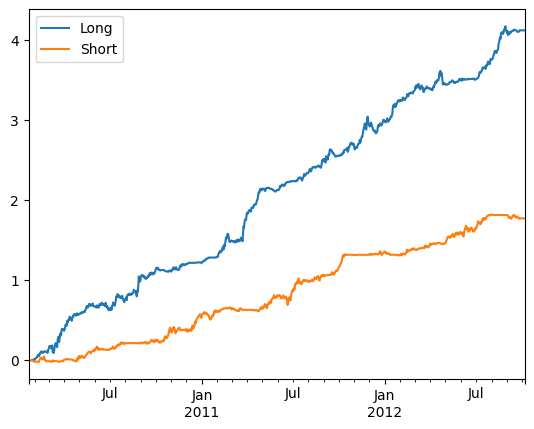

In [347]:
rollingret.df_pnl_capital_long_short.groupby(axis=1, level=0).sum().cumsum().plot()


<Axes: >

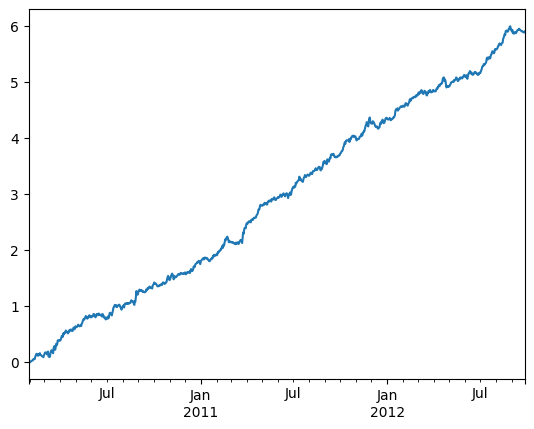

In [341]:
rollingret.df_pnl_capital.cumsum().sum(axis=1).plot()

<Axes: >

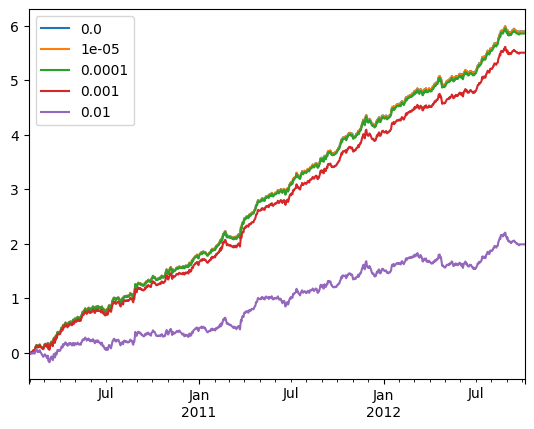

In [330]:
rollingret.df_pnl_with_tc.groupby(level=0 ,axis=1).sum().cumsum().plot()

In [323]:
rollingret.df_stats_with_tc

,daily_ret,daily_std,ann_ret,ann_std,sharpe,average_dd,max_dd
0.00000,0.001201,0.004769,0.302614,0.075698,3.997645,0.005569,0.040064
0.00001,0.001200,0.004769,0.302414,0.075699,3.994970,0.005573,0.040079
0.00010,0.001193,0.004769,0.300609,0.075703,3.970889,0.005616,0.040215
0.00100,0.001121,0.004772,0.282564,0.075754,3.730020,0.006087,0.041578
0.01000,0.000405,0.004833,0.102108,0.076718,1.330957,0.016119,0.058716


In [263]:
ori_stats = calc_stats(strat1.df_pnl_capital)
ori_stats

{'daily_ret': 0.000995278459404414,
 'daily_std': 0.004896383803153869,
 'ann_ret': 0.2508101717699123,
 'ann_std': 0.07772768320001865,
 'sharpe': 3.226780491121755,
 'average_dd': 0.0069399901454861536,
 'max_dd': 0.039620885640816006}

In [307]:
strat1.df_robustness_stats

Cross-Section                                                               \
      daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd   
0      0.000331  0.004268  0.083296  0.067750  1.229471   0.014876  0.087674   
1      0.000191  0.004476  0.048018  0.071052  0.675813   0.031425  0.096558   
2      0.000240  0.004471  0.060375  0.070974  0.850665   0.028210  0.091004   
3      0.000211  0.004563  0.053078  0.072428  0.732837   0.025395  0.115774   
4      0.000189  0.004204  0.047719  0.066730  0.715109   0.034430  0.103152   
5      0.000114  0.004234  0.028670  0.067206  0.426600   0.030144  0.086584   
6      0.000077  0.004261  0.019436  0.067646  0.287316   0.030537  0.093386   
7      0.000531  0.004410  0.133752  0.070007  1.910558   0.017083  0.072411   
8      0.000100  0.004429  0.025235  0.070309  0.358911   0.035028  0.108274   
9      0.000288  0.004384  0.072662  0.069590  1.044137   0.014152  0.062081   

  Time-Series                      ...      Both                       \
    daily_ret daily_std   ann_ret  ...    sharpe average_dd    max_dd   
0   -0.000070  0.004921 -0.017555  ...  0.413826   0.038065  0.096968   
1    0.000120  0.004784  0.030174  ...  0.730438   0.023752  0.074432   
2    0.000025  0.004990  0.006187  ...  0.132967   0.056888  0.199569   
3    0.000033  0.004886  0.008334  ... -0.485803   0.116769  0.211554   
4    0.000165  0.004801  0.041558  ...  0.254189   0.030113  0.086701   
5   -0.000120  0.004866 -0.030128  ...  0.372831   0.035070  0.095827   
6   -0.000198  0.004924 -0.049984  ... -0.756469   0.194234  0.353882   
7    0.000042  0.004925  0.010520  ...  0.282165   0.032347  0.143101   
8    0.000188  0.004832  0.047412  ...  0.581377   0.029465  0.096300   
9    0.000108  0.004775  0.027102  ... -0.095130   0.046639  0.113911   

  Execution                                                               
  daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd  
0  0.000995  0.004896  0.250810  0.077728  3.226780   0.006940  0.039621  
1  0.000921  0.004906  0.232068  0.077885  2.979620   0.007505  0.048692  
2  0.000841  0.004916  0.211869  0.078040  2.714873   0.008185  0.050591  
3  0.000761  0.004928  0.191781  0.078230  2.451494   0.009582  0.047519  
4  0.000695  0.004973  0.175071  0.078939  2.217795   0.011413  0.059982  
5  0.000613  0.005030  0.154393  0.079842  1.933722   0.013204  0.065244  
6  0.000531  0.005003  0.133721  0.079416  1.683802   0.014337  0.073277  
7  0.000487  0.005033  0.122731  0.079903  1.536004   0.015873  0.063543  
8  0.000444  0.005007  0.111784  0.079477  1.406487   0.017048  0.060820  
9  0.000410  0.004980  0.103250  0.079049  1.306159   0.016897  0.060275  

[10 rows x 28 columns]

<Axes: >

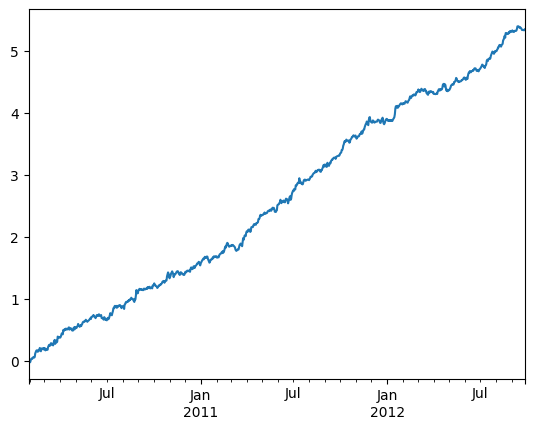

In [298]:
strat2.df_pnl_capital.cumsum().sum(axis=1).plot()

In [313]:
cost = 10/1_000_000
cost

1e-05

In [278]:
strat1.df_robustness_stats

Cross-Section                                                               \
      daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd   
0      0.000331  0.004268  0.083296  0.067750  1.229471   0.014876  0.087674   
1      0.000191  0.004476  0.048018  0.071052  0.675813   0.031425  0.096558   
2      0.000240  0.004471  0.060375  0.070974  0.850665   0.028210  0.091004   
3      0.000211  0.004563  0.053078  0.072428  0.732837   0.025395  0.115774   
4      0.000189  0.004204  0.047719  0.066730  0.715109   0.034430  0.103152   
5      0.000114  0.004234  0.028670  0.067206  0.426600   0.030144  0.086584   
6      0.000077  0.004261  0.019436  0.067646  0.287316   0.030537  0.093386   
7      0.000531  0.004410  0.133752  0.070007  1.910558   0.017083  0.072411   
8      0.000100  0.004429  0.025235  0.070309  0.358911   0.035028  0.108274   
9      0.000288  0.004384  0.072662  0.069590  1.044137   0.014152  0.062081   

  Time-Series                      ...      Both                       \
    daily_ret daily_std   ann_ret  ...    sharpe average_dd    max_dd   
0   -0.000070  0.004921 -0.017555  ...  0.413826   0.038065  0.096968   
1    0.000120  0.004784  0.030174  ...  0.730438   0.023752  0.074432   
2    0.000025  0.004990  0.006187  ...  0.132967   0.056888  0.199569   
3    0.000033  0.004886  0.008334  ... -0.485803   0.116769  0.211554   
4    0.000165  0.004801  0.041558  ...  0.254189   0.030113  0.086701   
5   -0.000120  0.004866 -0.030128  ...  0.372831   0.035070  0.095827   
6   -0.000198  0.004924 -0.049984  ... -0.756469   0.194234  0.353882   
7    0.000042  0.004925  0.010520  ...  0.282165   0.032347  0.143101   
8    0.000188  0.004832  0.047412  ...  0.581377   0.029465  0.096300   
9    0.000108  0.004775  0.027102  ... -0.095130   0.046639  0.113911   

  Execution                                                               
  daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd  
0  0.000995  0.004896  0.250810  0.077728  3.226780   0.006940  0.039621  
1  0.000921  0.004906  0.232068  0.077885  2.979620   0.007505  0.048692  
2  0.000841  0.004916  0.211869  0.078040  2.714873   0.008185  0.050591  
3  0.000761  0.004928  0.191781  0.078230  2.451494   0.009582  0.047519  
4  0.000695  0.004973  0.175071  0.078939  2.217795   0.011413  0.059982  
5  0.000613  0.005030  0.154393  0.079842  1.933722   0.013204  0.065244  
6  0.000531  0.005003  0.133721  0.079416  1.683802   0.014337  0.073277  
7  0.000487  0.005033  0.122731  0.079903  1.536004   0.015873  0.063543  
8  0.000444  0.005007  0.111784  0.079477  1.406487   0.017048  0.060820  
9  0.000410  0.004980  0.103250  0.079049  1.306159   0.016897  0.060275  

[10 rows x 28 columns]

In [253]:
rollingret.df_strat_capital_pnl.corr()

,HighLow,Trend
HighLow,1.000000,0.599806
Trend,0.599806,1.000000


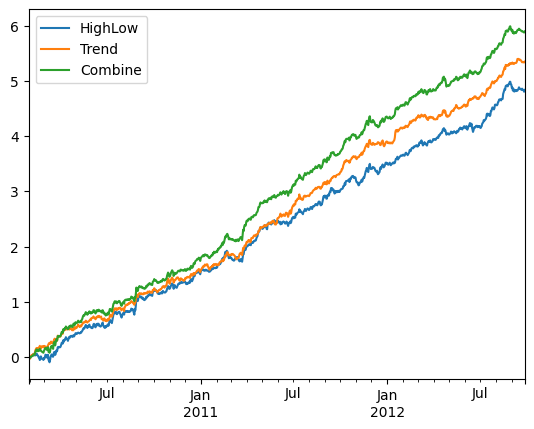

In [254]:
rollingret.df_strat_capital_pnl.cumsum().plot()
rollingret.df_pnl_capital.cumsum().sum(axis=1).plot()
plt.legend(['HighLow', 'Trend', 'Combine'])


In [251]:
rollingret.df_pnl_nominal.sum(axis=1).std() * np.sqrt(252), rollingret.df_strat_nominal_pnl.std() * np.sqrt(252)

(1234756.4337062468,
 HighLow    1.225832e+06
 Trend      1.222024e+06
 dtype: float64)

### How do we combine strategies?

Should we combine positions or forecast? The answer is positions(?)

- Must have a df_strat_weight for weightage of each strat at every point in time

- using df_strat_weight, we can get the df_forecast

In [61]:
strat1.df_pnl_nominal.cumsum().sum(axis=1).plot()
strat2.df_pnl_nominal.cumsum().sum(axis=1).plot()

AttributeError: 'Strat1' object has no attribute 'df_pnl_nominal'

In [53]:
pd.concat([strat1.df_pnl_nominal.sum(axis=1), strat2.df_pnl_nominal.sum(axis=1)], axis=1).std()

0    80479.806467
1    71628.244094
dtype: float64

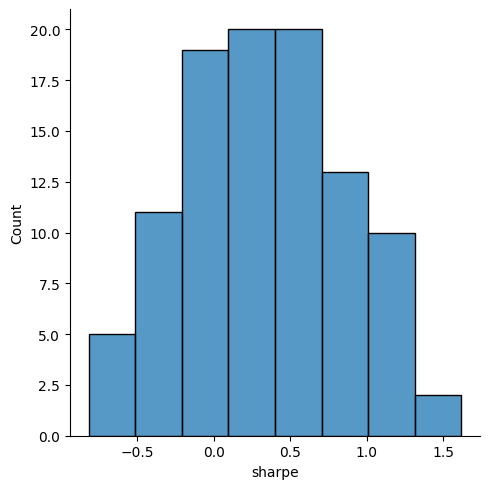

In [28]:
sns.displot(pd.DataFrame(strat1.time_stats_list)['sharpe'])

<Axes: >

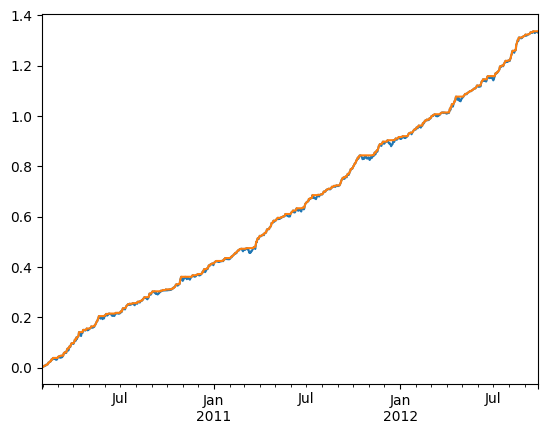

In [611]:
pnl = strat1.df_pnl_capital.dropna(how='all', axis=0).mean(axis=1)
pnl.cumsum().plot()
pnl.cumsum().cummax().plot()

In [16]:



# Sample data creation
np.random.seed(1)
t = 5
df_position = pd.DataFrame(np.random.randn(t, 3), columns=['Asset1', 'Asset2', 'Asset3']).round(2)
df_eligibles = pd.DataFrame(np.random.choice([0, 1], size=(t, 3)), columns=['Asset1', 'Asset2', 'Asset3'])

display(df_position)
display(df_eligibles)


,Asset1,Asset2,Asset3
0,1.62,-0.61,-0.53
1,-1.07,0.87,-2.30
2,1.74,-0.76,0.32
3,-0.25,1.46,-2.06
4,-0.32,-0.38,1.13


,Asset1,Asset2,Asset3
0,1,0,0
1,1,0,0
2,1,1,1
3,0,1,0
4,0,1,1


In [17]:
a = shuffle_weights(df_position, df_eligibles, 'cross')
a

,Asset1,Asset2,Asset3
0,1.62,-0.61,-0.53
1,-1.07,0.87,-2.30
2,1.74,-0.76,0.32
3,-0.25,1.46,-2.06
4,-0.32,-0.38,1.13


In [18]:
b = shuffle_weights(df_position, df_eligibles, 'time')
b

,Asset1,Asset2,Asset3
0,1.62,-0.61,-0.53
1,1.74,0.87,-2.30
2,-1.07,1.46,0.32
3,-0.25,-0.38,-2.06
4,-0.32,-0.76,1.13


In [515]:
%%timeit
# Shuffling df_position only for eligible assets
for col in df_position.columns:
    eligible_indices = df_eligibles.index[df_eligibles[col] == 1].tolist()
    shuffled_values = df_position.loc[eligible_indices, col].sample(frac=1).values
    df_position.loc[eligible_indices, col] = shuffled_values

df_position_shuffled = df_position.copy()


5.26 ms ± 639 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [516]:
%%timeit
for idx in df_position.index:
    eligible_assets = df_eligibles.columns[df_eligibles.loc[idx] == 1]
    shuffled_values = df_position.loc[idx, eligible_assets].sample(frac=1).values
    df_position.loc[idx, eligible_assets] = shuffled_values



6.09 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [439]:

positions, eligibles = deepcopy(df_position.values).T, deepcopy(df_eligibles.values).T
new_positions = deepcopy(positions)

for idx in range(positions.shape[1]):
    print('idx', idx)
    print(positions[:, idx])
    print(eligibles[:, idx])
    eligible_indices = np.where(eligibles[:, idx] == 1)[0]
    eligible_values = deepcopy(positions[:, idx][eligible_indices])
    print('......eligible_indices')
    print(eligible_indices)
    print('......eligible_values')
    print(eligible_values)
    
    np.random.shuffle(eligible_values)
    print('.......shuffled_values')
    print(eligible_values)
    new_positions[:, idx][eligible_indices] = eligible_values


idx 0
[ 0.05056171  0.49995133 -0.99590893]
[1 0 0]
......eligible_indices
[0]
......eligible_values
[0.05056171]
.......shuffled_values
[0.05056171]
idx 1
[ 0.69359851 -0.41830152 -1.58457724]
[1 0 1]
......eligible_indices
[0 2]
......eligible_values
[ 0.69359851 -1.58457724]
.......shuffled_values
[-1.58457724  0.69359851]
idx 2
[-0.64770677  0.59857517  0.33225003]
[1 0 0]
......eligible_indices
[0]
......eligible_values
[-0.64770677]
.......shuffled_values
[-0.64770677]
idx 3
[-1.14747663  0.61866969 -0.08798693]
[1 0 1]
......eligible_indices
[0 2]
......eligible_values
[-1.14747663 -0.08798693]
.......shuffled_values
[-0.08798693 -1.14747663]


In [442]:
positions.T

array([[ 0.05056171,  0.49995133, -0.99590893],
       [ 0.69359851, -0.41830152, -1.58457724],
       [-0.64770677,  0.59857517,  0.33225003],
       [-1.14747663,  0.61866969, -0.08798693]])

In [443]:
new_positions.T

array([[ 0.05056171,  0.49995133, -0.99590893],
       [-1.58457724, -0.41830152,  0.69359851],
       [-0.64770677,  0.59857517,  0.33225003],
       [-0.08798693,  0.61866969, -1.14747663]])

In [363]:
df_position_shuffled_time = optimized_shuffle_v2(df_position, df_eligibles, 0)

ValueError: Shape of passed values is (3, 4), indices imply (3, 3)

In [348]:
df_position_shuffled_asset = optimized_shuffle_v2(df_position, df_eligibles, 1)

df_position_shuffled_asset

,Asset1,Asset2,Asset3
0,0.332250,-0.995909,-0.647707
1,-1.584577,0.050562,-0.418302
2,0.693599,0.499951,0.598575


,Asset1,Asset2,Asset3
0,0.693599,0.050562,-0.647707
1,0.332250,0.499951,-0.418302
2,-1.584577,-0.995909,0.598575


In [329]:
df_position_shuffled_time

,Asset1,Asset2,Asset3
0,0.693599,-0.418302,-1.584577
1,0.499951,-0.995909,-0.647707
2,0.332250,0.598575,0.050562


In [274]:
%%timeit


14.3 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [281]:
%%timeit
eligible_assets = df_eligibles.columns[df_eligibles.loc[idx] == 1]

214 µs ± 30 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [282]:
%%timeit
shuffled_values = df_position.loc[idx, eligible_assets].sample(frac=1).values

566 µs ± 74.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [284]:
%%timeit
df_position.loc[idx, eligible_assets] = shuffled_values

286 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
df_position_cross_shuffled


df_position_original, df_eligibles_original, df_position_shuffled



In [267]:
df_position_cross_shuffled

,Asset1,Asset2,Asset3
0,0.499951,-0.647707,-0.995909
1,0.046136,0.693599,-1.584577
2,-1.156816,0.618670,2.223360
3,-1.147477,0.598575,-0.087987
4,0.350997,0.332253,1.692358
5,1.546979,0.050562,-0.606887
6,0.723342,0.332250,-0.418302
7,0.054433,0.159893,-1.208948
8,-0.982992,0.394295,0.425072
9,-1.112812,1.635748,-1.360966


In [268]:
df_position_original

,Asset1,Asset2,Asset3
0,0.050562,0.499951,-0.995909
1,0.693599,-0.418302,-1.584577
2,-0.647707,0.598575,0.332250
3,-1.147477,0.618670,-0.087987
4,0.425072,0.332253,-1.156816
5,0.350997,-0.606887,1.546979
6,0.723342,0.046136,-0.982992
7,0.054433,0.159893,-1.208948
8,2.223360,0.394295,1.692358
9,-1.112812,1.635748,-1.360966


In [37]:
df_vol = df_ret.rolling(25).std()
df_dollar_vol = df_price.diff().rolling(25).std()
df_forecast = df_signal.copy()

df_forecast_chips = df_forecast.abs().sum(axis=1)
positions =  df_forecast.div(df_forecast_chips, axis='index') / (df_price * contract_size) 
df_nominal= (positions.abs() * (df_price * contract_size))
df_nominal_sign = (positions * (df_price * contract_size))
df_units = df_nominal_sign/contract_size
df_nominal_tot = df_nominal.sum(axis=1)
df_weights = positions * (df_price * contract_size)
df_weights = df_weights.div(df_nominal_tot, axis='index')

df_asset_dollar_vol = df_vol * df_nominal

# ## Vol Target On Asset Level
# asset_dollar_target_vol = 10000
# df_asset_scalar = asset_dollar_target_vol/df_asset_dollar_vol

# df_pnl = (df_nominal_sign * df_ret)
# df_pnl_rolling_vol = df_pnl.sum(axis=1).rolling(25).std().mul(np.sqrt(252))
# nominal_target_vol = 10000
# df_strat_scalar = nominal_target_vol/df_pnl_rolling_vol


# positions_vol_adj = positions.mul(df_strat_scalar.shift(2), axis='index')
# df_nominal_vol_adj= (positions_vol_adj.abs() * (df_price * contract_size))
# df_nominal_sign_vol_adj = (positions_vol_adj * (df_price * contract_size))
# df_units_vol_adj = df_nominal_sign_vol_adj/contract_size
# df_nominal_tot_vol_adj = df_nominal_vol_adj.sum(axis=1)
# df_weights_vol_adj = positions_vol_adj * (df_price * contract_size)
# df_weights_vol_adj = df_weights_vol_adj.div(df_nominal_tot_vol_adj, axis='index')
# df_pnl_vol_adj = (df_nominal_sign_vol_adj * df_ret)



In [42]:
df_asset_dollar_vol

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
995,0.000029,0.010041,0.036382,0.006436,0.028866
996,0.001732,0.006483,0.012990,0.014933,0.042734
997,0.001550,0.003441,0.000416,0.021476,0.059113
998,0.000377,0.007280,0.021484,0.015890,0.040791


<Axes: >

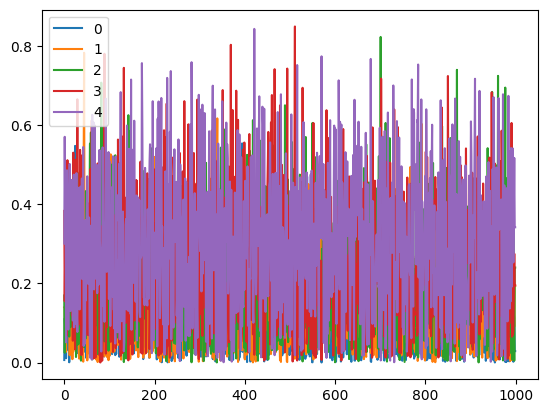

In [39]:
df_nominal.plot()

In [41]:
df_asset_dollar_vol.describe()

,0,1,2,3,4
count,976.000000,976.000000,976.000000,976.000000,976.000000
mean,0.001872,0.005818,0.013601,0.020332,0.029763
std,0.001589,0.008897,0.023111,0.013694,0.017456
min,0.000001,0.000008,0.000008,0.000005,0.000068
25%,0.000723,0.002235,0.005554,0.009742,0.016070
50%,0.001535,0.004754,0.011088,0.018091,0.028569
75%,0.002622,0.007798,0.018785,0.028875,0.041544
max,0.013427,0.247825,0.673768,0.079872,0.084461


<Axes: >

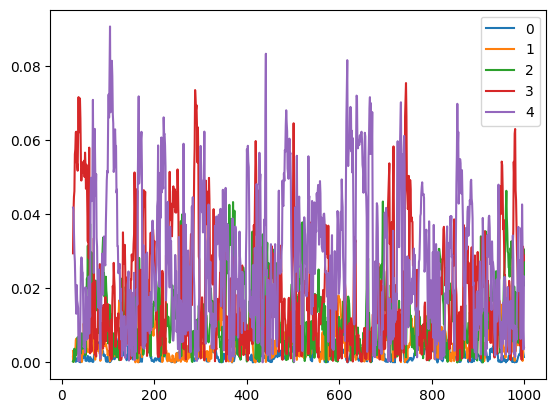

In [22]:
df_asset_dollar_vol.plot()

In [19]:
df_asset_dollar_vol.iloc[240:245]

,0,1,2,3,4
240,0.001152,0.000560,0.035143,0.142920,0.005826
241,0.001591,0.000207,0.032740,0.147599,0.006150
242,0.002326,0.000143,0.037005,0.132647,0.008358
243,0.002161,0.000001,0.023731,0.149459,0.018591
244,0.002121,0.000120,0.025364,0.176459,0.018928


<Axes: >

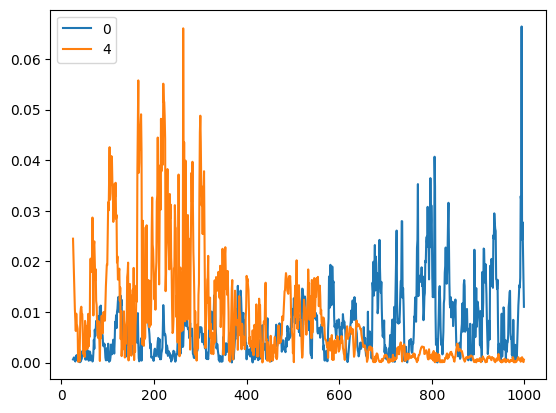

In [14]:
df_asset_dollar_vol.iloc[:, [0, 4]].abs().plot()

In [9]:
df_dollar_vol

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
995,0.003476,-0.002174,0.018224,0.010873,-0.042618
996,0.003890,-0.000417,0.009031,0.026760,-0.031049
997,0.003177,0.002142,0.021213,0.031245,0.008675
998,0.002275,0.004452,0.030656,0.027382,-0.003475


In [8]:
df_weights, df_nominal_sign, df_units, df_pnl = main_backtester(df_forecast, df_price, contract_size, vol_target=True)

NameError: name 'df_forecast' is not defined

In [9]:
df_pnl.sum(axis=1).cumsum().plot()

NameError: name 'df_pnl' is not defined

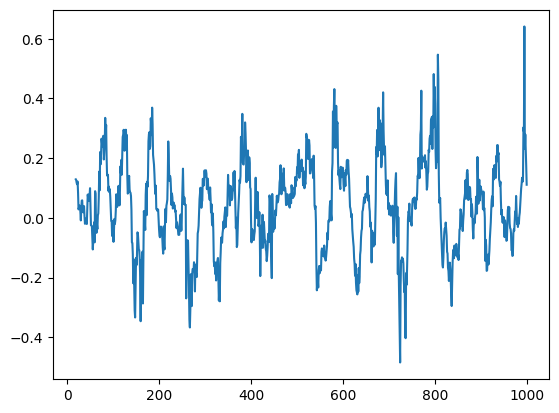

In [224]:
df_pnl.sum(axis=1).mean()

0.010692118667275768

<Axes: >

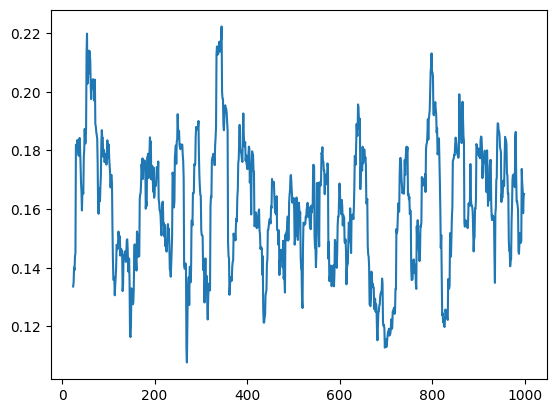

In [225]:
df_pnl_rolling_vol.plot()

<Axes: >

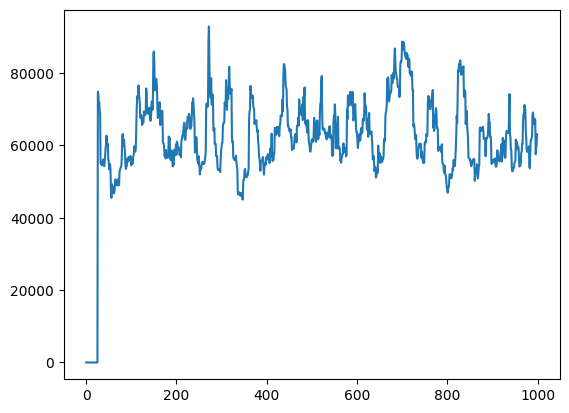

In [227]:
df_nominal_tot_vol_adj.plot()

<Axes: >

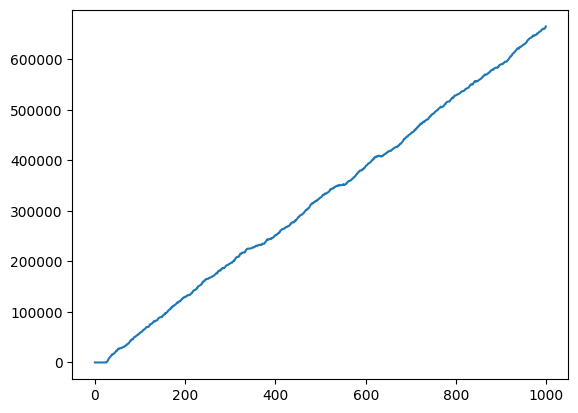

In [228]:
df_pnl_vol_adj.cumsum().sum(axis=1).plot()

<Axes: >

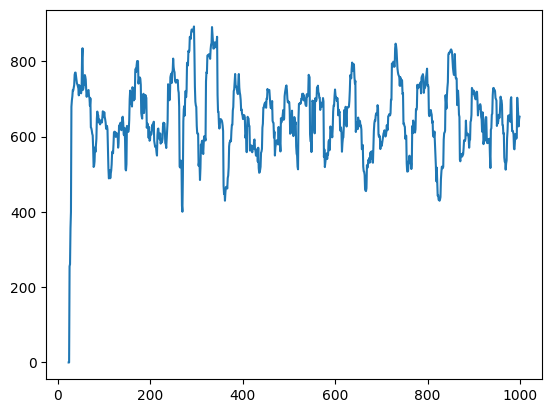

In [222]:
df_pnl_vol_adj.sum(axis=1).rolling(25).std().mul(np.sqrt(252)).plot()

In [232]:
df_pnl_vol_adj.sum(axis=1).std()*(252)

167040.20321894187

<Axes: >

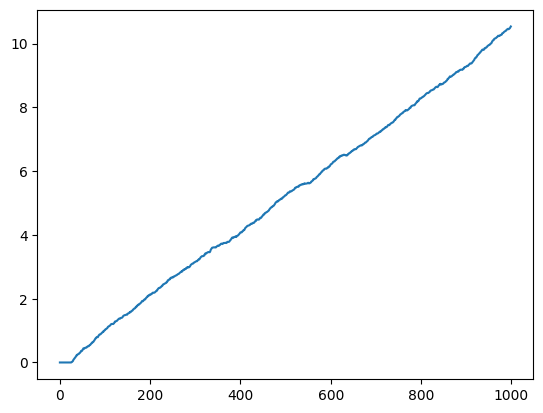

In [128]:
df_pnl_vol_adj.cumsum().sum(axis=1).plot()

In [129]:
(df_pnl_vol_adj.sum(axis=1).rolling(25).std().mul(np.sqrt(252)).equals(df_pnl.sum(axis=1).rolling(25).std().mul(np.sqrt(252))))

False

In [133]:
(df_pnl_vol_adj.sum(axis=1).rolling(25).std().mul(np.sqrt(252)))

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
995    0.160368
996    0.158339
997    0.150468
998    0.157040
999    0.156697
Length: 1000, dtype: float64

In [130]:
df_pnl.sum(axis=1).rolling(25).std().mul(np.sqrt(252))

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
995    0.160368
996    0.158339
997    0.150468
998    0.157040
999    0.156697
Length: 1000, dtype: float64

In [131]:
df_nominal_tot.iloc[550:555], df_signal.iloc[550:555]

(550    19.371596
 551    17.596265
 552    17.482828
 553    19.150062
 554    20.901946
 dtype: float64,
             0         1         2         3         4
 550 -0.485662  0.053669  0.211132  0.451722  0.098744
 551 -0.487816  0.031113  0.557887  0.208606 -0.063022
 552 -0.404179 -0.103309  0.646424  0.335247  0.032221
 553 -0.118523 -0.110357  0.326024  0.202721 -0.310822
 554  0.102864  0.164868  0.215727  0.381298 -0.370812)

In [43]:
df_forecast.iloc[550:555], df_forecast_chips.iloc[550:555]

(            0         1         2         3         4
 550 -0.485662  0.053669  0.211132  0.451722  0.098744
 551 -0.487816  0.031113  0.557887  0.208606 -0.063022
 552 -0.404179 -0.103309  0.646424  0.335247  0.032221
 553 -0.118523 -0.110357  0.326024  0.202721 -0.310822
 554  0.102864  0.164868  0.215727  0.381298 -0.370812,
 550    1.300928
 551    1.348444
 552    1.521380
 553    1.068447
 554    1.235569
 dtype: float64)

In [46]:
df_forecast.iloc[550:555].div(df_forecast_chips.iloc[550:555] ,axis='index') * vol_target / ((df_vol* df_price * contract_size)).iloc[550:555]

,0,1,2,3,4
550,-0.000462,0.005110,0.001041,0.005424,0.000519
551,-0.000445,0.002712,0.002564,0.002467,-0.000307
552,-0.000314,-0.007611,0.002651,0.003495,0.000144
553,-0.000127,-0.011371,0.002104,0.002995,-0.002040
554,0.000086,0.014637,0.001209,0.005788,-0.002102


In [33]:
(df_vol).iloc[550:555]

,0,1,2,3,4
550,0.020015,0.021513,0.026528,0.019621,0.018765
551,0.020031,0.021922,0.028907,0.019056,0.019099
552,0.020415,0.023910,0.028170,0.018952,0.018519
553,0.020705,0.023837,0.025456,0.019146,0.017861
554,0.021992,0.023706,0.025559,0.015952,0.018010


In [54]:
np.linalg.norm(np.array([0, 1, 2]) * np.array([3, -4, -5]), ord=1)

14.0

In [ ]:

vol_target = 0.2
nominals = pd.Series([10000, 10000])
shift = 1
vol_target_nominals = nominals * vol_target

df_units = df_signal * df_price
df_nominal = contract_size * df_units

df_dollar_vol = df_vol * df_nominal * np.sqrt(252)

df_vol_scalar = vol_target_nominals/df_dollar_vol.abs()

df_units_vol_adj = df_units * df_vol_scalar
df_nominal_vol_adj = df_units_vol_adj * contract_size


df_dollar_vol_adj = df_vol * df_nominal_vol_adj.shift(1) * np.sqrt(252)
df_dollar_vol_adj

25.0

In [113]:
df_nominal/nominals

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,44.624624,1.035151
996,48.796782,1.039868
997,42.473398,1.499702
998,42.290934,1.419321


In [107]:
df_units

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,17849.849707,10351.508219
996,19518.712743,10398.682797
997,16989.359327,14997.021537
998,16916.373758,14193.206725


In [108]:
df_nominal_pnl = df_nominal * df_ret
df_nominal_pnl

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,8496.672502,-177.939242
996,24159.479969,244.532433
997,9102.518045,261.226275
998,5457.448511,367.014740


In [109]:
### vol target at instrument level
### vol target at strategy
## vol target function should be general enough
def vol_target(df_)



SyntaxError: expected ':' (1371181930.py, line 4)

<Axes: >

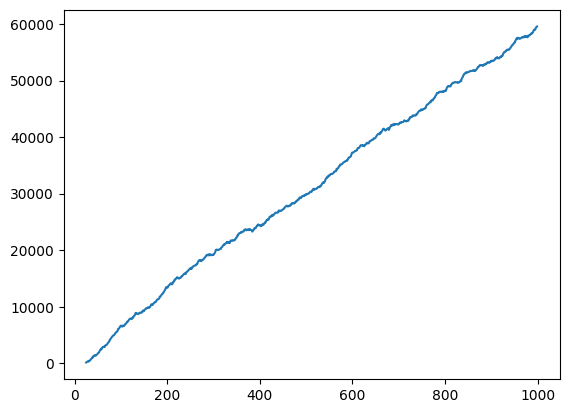

In [110]:
(df_nominal_vol_adj.shift(1) * df_ret).cumsum().mean(axis=1).plot()

In [75]:
df_dollar_vol.dropna()

,0,1
25,1.596862,-0.043857
26,0.326613,0.061795
27,4.547549,0.073704
28,1.899829,0.074631
29,1.408017,0.134055
...,...,...
995,1.893082,-0.020742
996,2.880643,-0.036059
997,3.454803,-0.038926
998,2.399537,0.021563


In [73]:
df_signal

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
995,0.828029,-0.198126
996,0.904640,-0.212979
997,0.623042,0.115612
998,0.595480,0.029203


In [46]:
vol_target_nominals

0    2000.0
1    2000.0
dtype: float64

In [36]:
df_price

,0,1
0,0.998161,0.970733
1,1.019757,0.966087
2,1.009740,0.946721
3,1.028296,0.925824
4,1.041180,0.915427
...,...,...
995,0.480418,0.636732
996,0.499400,0.645338
997,0.505108,0.650126
998,0.506575,0.660436


In [35]:
df_nominal


,0,1
0,NaN,NaN
1,45.460869,2.156568
2,12.782722,-0.701146
3,77.683872,-0.059588
4,-91.196474,-3.742185
...,...,...
995,12.133242,-3.656187
996,25.121626,-0.461625
997,48.730872,-0.230502
998,-64.430984,2.057007


In [40]:
df_signal

,0,1
0,1.783204,2.232272
1,0.506377,-0.740605
2,3.021849,-0.064362
3,-3.503581,-4.087912
4,-0.678977,-2.527243
...,...,...
995,2.012146,-0.715323
996,3.859044,-0.354550
997,-5.087573,3.114620
998,0.810059,-1.234775


In [42]:
0.5*0.8*25

10.0

In [21]:
capitals, nominal_rets, capital_rets = [10000.0],[0.0],[0.0]
nominals, leverages = [],[]
n_insts = df_ret.shape[1]
day_pnls_indvs, nominal_rets_indvs, capital_rets_indvs = [np.zeros(n_insts)], [np.zeros(n_insts)], [np.zeros(n_insts)]

,0,1
0,NaN,NaN
1,1.818435,2.156568
2,0.511309,-0.701146
3,3.107355,-0.059588
4,-3.647859,-3.742185
...,...,...
995,0.485330,-3.656187
996,1.004865,-0.461625
997,1.949235,-0.230502
998,-2.577239,2.057007


In [15]:
%%timeit
a = (df_pos.shift(1) * df_ret).cumsum()

528 µs ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
